# Scikit learn Tree

In [1]:
import os
import sys
import re
import random
import math
import scipy
import numpy as np
import pandas as pd
from time import time
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.cm as cm

from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold # import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

from mpl_toolkits.mplot3d import Axes3D
cmapRdYlGn = cm.get_cmap('RdYlGn')
cmap = cm.coolwarm

from minisom import MiniSom

challenge_data_folder = "./challenge_data"

#outlier detection http://scikit-learn.org/stable/modules/outlier_detection.html

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pdAllData = pd.read_csv(challenge_data_folder+"/train.csv",keep_default_na=False) #Load training data NA filter FALSE to keep Not available data
columnTypesDict = pdAllData.dtypes.to_dict() #Infer part of the data schema
columnNames = list(columnTypesDict.keys()) #List of all features name

In [3]:
lb_make = LabelEncoder()

for featureCol in pdAllData:
    if pdAllData[featureCol].dtype=='object':
        pdAllData[featureCol] = lb_make.fit_transform(pdAllData[featureCol])
    else:
        continue
#pdAllData.head()
X = pdAllData.drop(['Id','SalePrice'],axis=1)
Y = pdAllData.SalePrice

kept_columnValues = list(X.columns.values)
X_scaled_array = StandardScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)

In [284]:
def getLogRMSE(estimatedPrice,realPrice):
    logRMSE = np.mean( (np.log(estimatedPrice) - np.log(realPrice))**2 )
    return np.sqrt(logRMSE)
def regressionTrees(X=X,X_outliers=[],Y_outliers=[],Y=Y,depth=6,min_samples_leaf=8,test_size=0.1,singleTree=True,forest=False,extraTrees=False,nb_estimator=20):
    #X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = test_size, random_state = 42)# np.random.randint(0,100))
    nkfold = int(1/test_size)
    foldNb = 0
    kf = KFold(n_splits=nkfold)
    test_errors = []
    training_errors = []
    X= np.array(X)
    Y=np.array(Y)
    X_outliers = np.array(X_outliers)
    Y_outliers = np.array(Y_outliers)
    
    for (train_index, test_index), (outliers_train,outliers_index) in zip(kf.split(X),kf.split(X_outliers)):
        X_outliers_test,X_outliers_train = X_outliers[outliers_index],X_outliers[outliers_train] #get a proportinal number of outliers to calculate error
        Y_outliers_test,Y_outliers_train = Y_outliers[outliers_index],Y_outliers[outliers_train]
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        X_train = np.concatenate((X_train,X_outliers_train))
        y_train = np.concatenate((y_train,Y_outliers_train))
        
        if singleTree: regressor = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth)
        elif forest: regressor = RandomForestRegressor(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        elif extraTrees: regressor = ExtraTreesClassifier(min_samples_leaf=min_samples_leaf,max_depth=depth,n_estimators=nb_estimator,random_state=42)#, max_depth=depth,min_samples_leaf=min_samples_leaf)
        
        regressor.fit(X_train, y_train)
        y_hat_test = regressor.predict(X_test)
        
        training_estimation = regressor.predict(X_train)
        y_hat_test_outliers = regressor.predict(X_outliers_test)
        
        y_hat_test = np.concatenate((y_hat_test,y_hat_test_outliers))
        y_test = np.concatenate((y_test,Y_outliers_test))
        
        test_errors.append(getLogRMSE(y_hat_test,y_test))
        training_errors.append(getLogRMSE(training_estimation,y_train))
        
    return np.mean(test_errors),np.mean(training_errors),regressor #test error train error

In [115]:
l = np.array([[1],[2],[5]])
l2 = np.array([[3],[0]])
np.concatenate((l,l2))

array([[1],
       [2],
       [5],
       [3],
       [0]])

### Launch until this

In [91]:
clf = DecisionTreeRegressor()
clf = clf.fit(X_scaled, Y)
feature_importances_forest = clf.feature_importances_
sort_index_forest = np.argsort(feature_importances)

clf = RandomForestRegressor()
clf = clf.fit(X_scaled, Y)
feature_importances = clf.feature_importances_
sort_index = np.argsort(feature_importances)

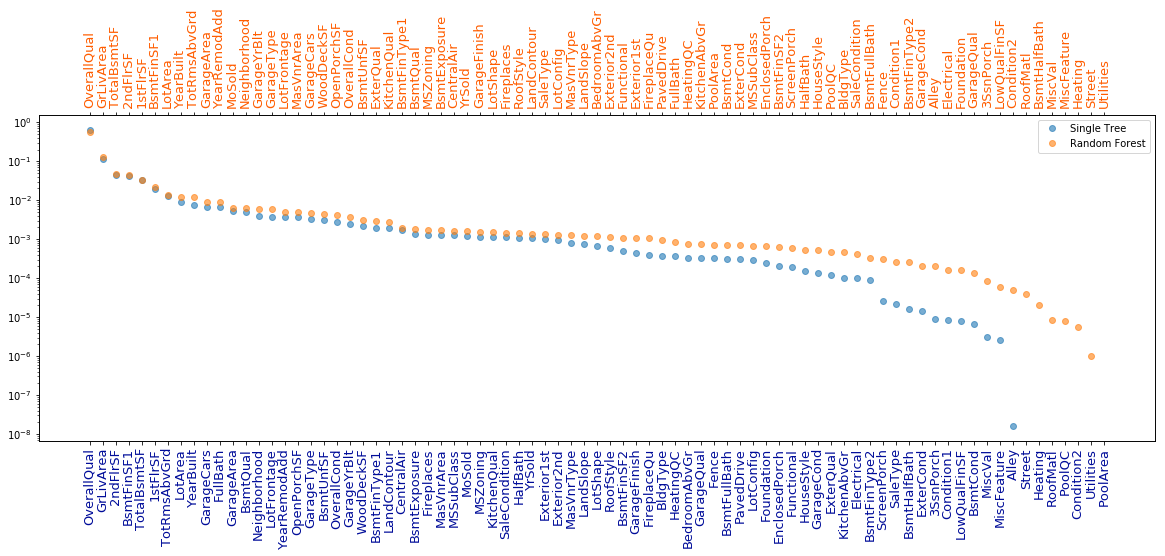

In [139]:
fig, ax =plt.subplots(figsize=(20,6))
ax.semilogy(np.sort(feature_importances_forest)[::-1],'o',label='Single Tree',alpha=0.6)
locs = ax.set_xticks(np.arange(79))
ax.set_xticklabels(np.array(kept_columnValues)[sort_index_forest][::-1], rotation='vertical',fontsize=13)
[x.set_color('#000c99') for x in ax.get_xticklabels()]

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(np.arange(79))


ax.semilogy(np.sort(feature_importances)[::-1],'o',label='Random Forest',alpha=0.6)
ax2.set_xticks(np.arange(79))
ax2.set_xticklabels(np.array(kept_columnValues)[sort_index][::-1], rotation='vertical',fontsize=13)
[x.set_color('#ff5d00') for x in ax2.get_xticklabels()]


pylab.ylabel("Feature Importance")
ax.legend()
plt.show()

In [105]:
sort_index_forest_desc = sort_index_forest[::-1]
test_errors = []
train_errors = []
#Study test error in respect to nb of feature selected
range_selection = range(1,len(sort_index_forest_desc))
for i in range_selection:
    selected_features = np.array(kept_columnValues)[sort_index_forest_desc[:i]]
    X_scaled_trimmed = X_scaled[selected_features]
    test_error,train_error,regressor = regressionTrees(X=X_scaled_trimmed,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    train_errors.append(train_error)
    test_errors.append(test_error)

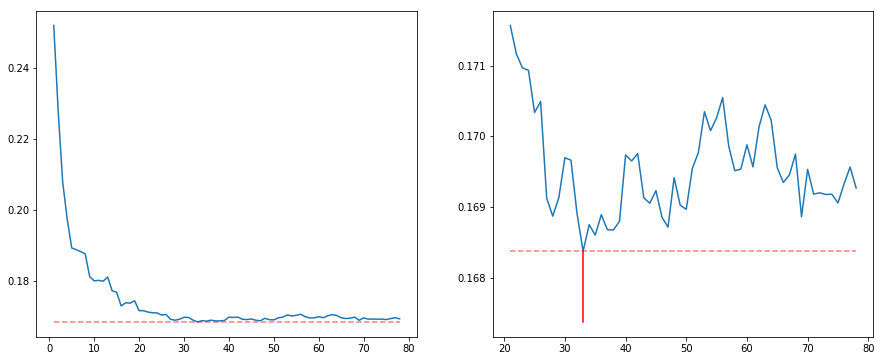

In [111]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(range_selection,test_errors)
plt.plot(range_selection,[np.min(test_errors)]*len(range_selection),'r--',alpha=0.5)


plt.subplot(122)
min_slice = 20
max_slice = 79
argmin = np.argmin(test_errors)
plt.plot(range_selection[min_slice:max_slice],test_errors[min_slice:max_slice])
plt.plot(range_selection[min_slice:max_slice],[np.min(test_errors)]*len(range_selection[min_slice:max_slice]),'r--',alpha=0.5)
argmin = np.argmin(test_errors)
plt.plot([argmin+1,argmin+1],[np.min(test_errors)-0.001,np.min(test_errors)],'r')
plt.show()

In [120]:
selected_features = np.array(kept_columnValues)[sort_index_forest_desc[:np.argmin(test_errors)+1]]
X_scaled_trimmed = X_scaled[selected_features]
test_error,train_error,regressor = regressionTrees(X=X_scaled_trimmed,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

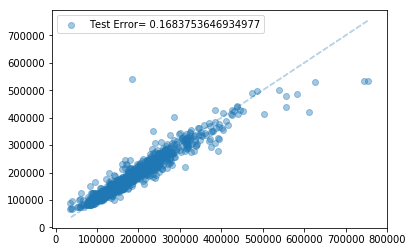

In [126]:
plt.plot(Y,Y,'--',alpha=0.3,label="")
plt.scatter(Y,regressor.predict(X_scaled_trimmed),alpha=0.4,label="Test Error= "+str(test_error))
plt.legend()
plt.show()

## PCA

In [91]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_scaled)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, Y], axis = 1)
finalDf.head()

,pc1,pc2,SalePrice
0,2.330400,0.627899,208500
1,0.199640,-2.276352,181500
2,2.756014,0.276600,223500
3,-1.448722,1.046888,140000
4,5.006460,0.870471,250000


In [132]:
testerror,trainerror,regressor = regressionTrees(X=principalDf,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

In [66]:
np.concatenate((regressor.predict(X),regressor.predict(X))).shape

(2400,)

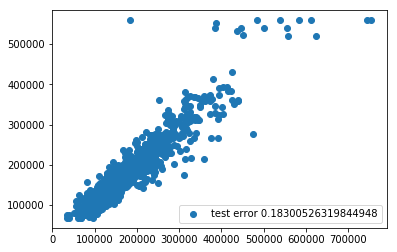

In [133]:
plt.scatter(Y,regressor.predict(principalDf),label='test error '+str(testerror))
plt.legend()
plt.show()

In [134]:
testErrors = []
for i in range(2,80):
    pca = PCA(n_components=i)
    principalComponents = pca.fit_transform(X_scaled_array)
    principalDf = pd.DataFrame(data = principalComponents)
    testerror,trainerror,regressor = regressionTrees(X=principalDf,Y=Y,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    testErrors.append(testerror)

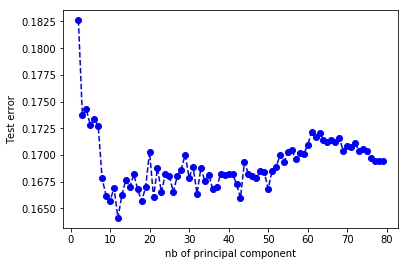

In [135]:
plt.plot(range(2,80),testErrors,'b--o')
plt.xlabel('nb of principal component')
plt.ylabel("Test error")
plt.show()

In [253]:
max(0,11)

11

In [257]:
def salePriceColor(hist,salePrice):
    index = [i for i,x in enumerate(hist[1]) if x<=salePrice][-1]
    return hist[0][max(0,index-1)]

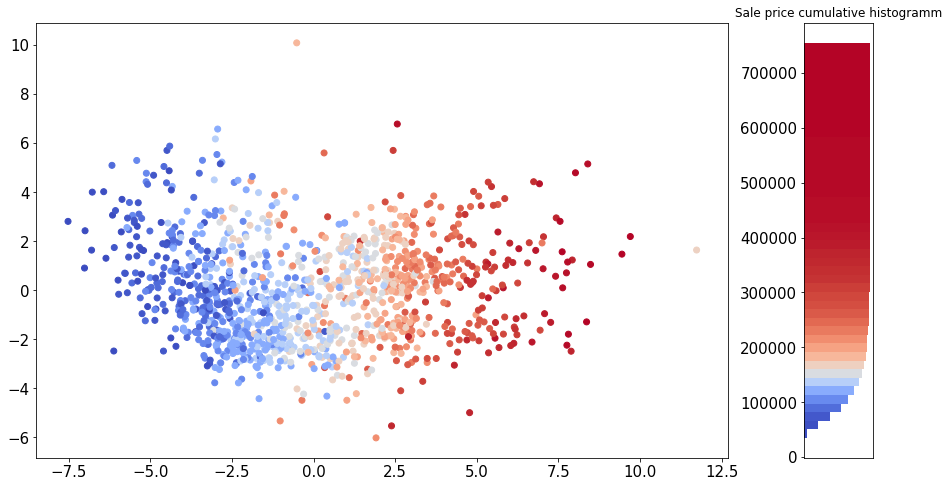

In [258]:
plt.figure(figsize=(15,8))
hist = plt.hist(Y,cumulative=True,normed=True,bins='auto')
for c, p in zip(hist[0], hist[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.clf()
plt.close()
def normHist(row):
    salePrice = row.SalePrice
    return salePriceColor(hist,salePrice)
colors = pdAllData.apply(normHist,axis=1)


plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(1, 2, width_ratios=[10, 1])
plt.subplot(gs[0])
sc = plt.scatter(finalDf.pc1,finalDf.pc2,c=colors,cmap=cmap)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
#plt.colorbar(sc,ticks=finalDf.SalePrice)
plt.subplot(gs[1])
histbis = plt.hist(finalDf.SalePrice,cumulative=True,normed=True,bins='auto',orientation='horizontal')
for c, p in zip(histbis[0], histbis[2]):
    plt.setp(p, 'facecolor', cmap(c))
plt.gca().set_xscale("log")
plt.title("Sale price cumulative histogramm")
plt.yticks(fontsize=15)
plt.tick_params(axis='x',which='both',bottom='off',labelbottom='off')
plt.show()

### Consider outliers

Automatically created module for IPython interactive environment


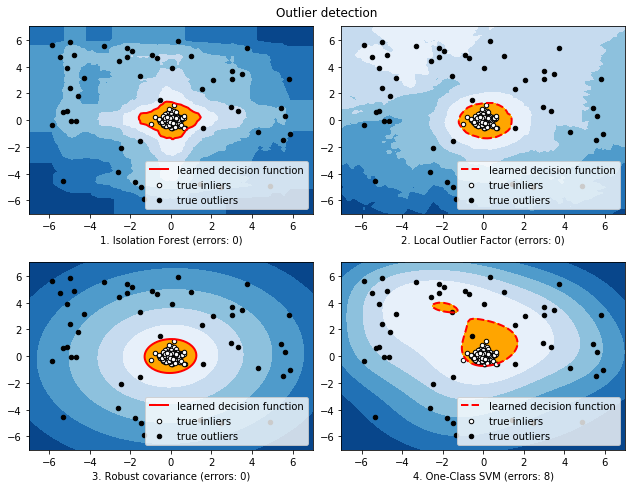

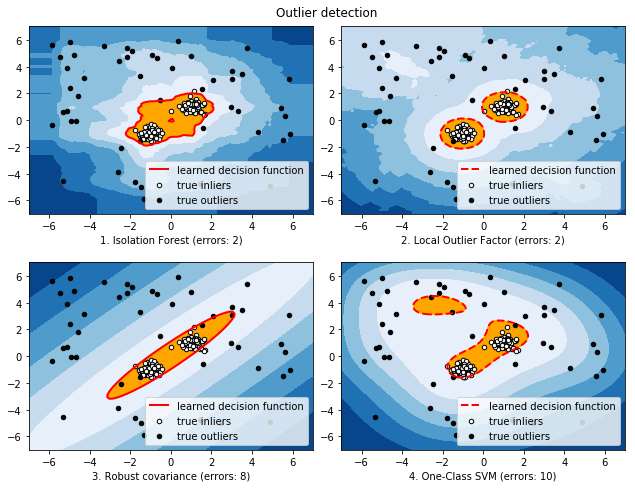

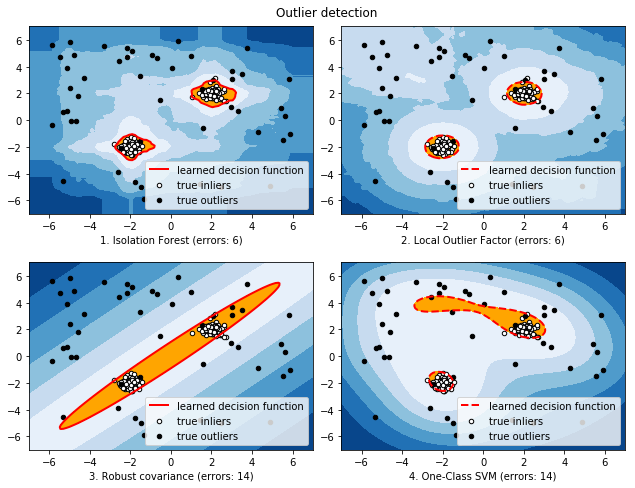

In [143]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

print(__doc__)

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=35,
        contamination=outliers_fraction)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(9, 7))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        if clf_name == "Local Outlier Factor":
            y_pred = clf.fit_predict(X)
            scores_pred = clf.negative_outlier_factor_
        else:
            
            
            
            clf.fit(X)
            scores_pred = clf.decision_function(X)
            y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        
        
        n_errors = (y_pred != ground_truth).sum()
        
        
        
        
        # plot the levels lines and the points
        if clf_name == "Local Outlier Factor":
            # decision_function is private for LOF
            Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(2, 2, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")

plt.show()

### Isolation forest

In [320]:
from sklearn.ensemble import IsolationForest
from scipy import stats

outliers_fraction = 0.05

def findOutliers_IsolationForest(X, outliers_fraction):
    clf = IsolationForest(max_samples=len(X), contamination=outliers_fraction, random_state=42)
    clf.fit(X)
    scores_pred = clf.decision_function(X)
    y_pred = clf.predict(X)
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    return scores_pred, y_pred, threshold

#scores_pred, y_pred, threshold = findOutliers_IsolationForest(Y.values.reshape(-1,1), outliers_fraction)
scores_pred, y_pred, threshold = findOutliers_IsolationForest(pdAllData, outliers_fraction)

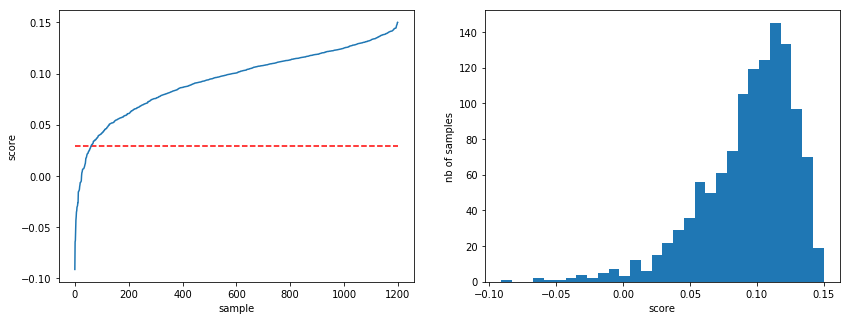

In [321]:
plt.figure(figsize=(14,5))
plt.subplot(121)
scores_pred_sorted = np.sort(scores_pred)
plt.plot([0,1199],[threshold]*2,'--',c='red')
plt.plot(scores_pred_sorted),plt.xlabel("sample"),plt.ylabel("score")
plt.subplot(122)
plt.hist(scores_pred_sorted, bins='auto'),plt.xlabel("score"),plt.ylabel("nb of samples")
plt.show()

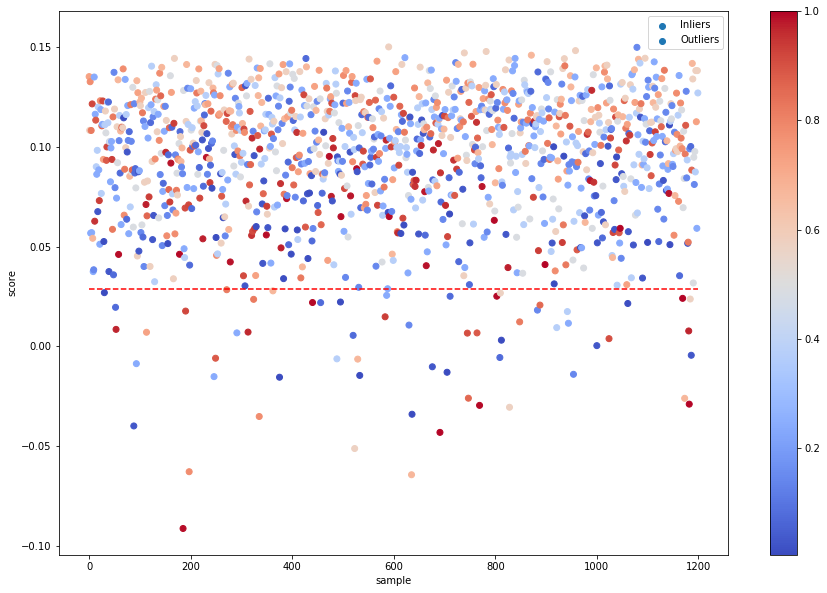

In [322]:
inlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==1])
outlier = np.array([[i,scores_pred[i]] for i,x in enumerate(y_pred) if x==-1])

plt.figure(figsize=(15,10))
plt.scatter(inlier.T[0],inlier.T[1],c=colors.filter(inlier.T[0]),cmap=cmap,label="Inliers")
plt.scatter(outlier.T[0],outlier.T[1],c=colors.filter(outlier.T[0]),cmap=cmap,label="Outliers")
plt.plot([0,1199],[threshold]*2,'--',c='red')
plt.colorbar()
plt.xlabel("sample")
plt.ylabel("score")
plt.legend()
plt.show()

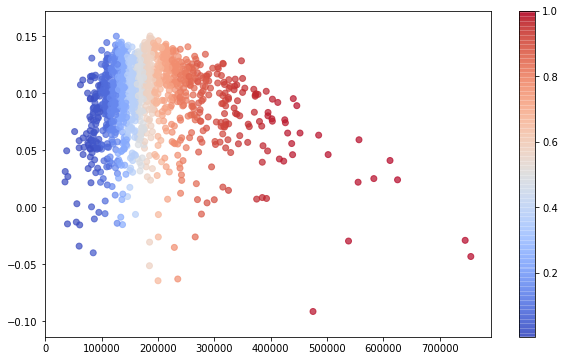

In [323]:
plt.figure(figsize=(10,6))
plt.scatter(Y,scores_pred,c=colors,cmap=cmap,alpha=0.7)
plt.colorbar()
plt.show()

In [324]:
outlier_index = np.where(y_pred==-1)[0]
X_WO = X.drop(outlier_index)
Y_WO = Y.drop(outlier_index)
X_outliers = X.filter(outlier_index,axis=0)
Y_outliers = Y.filter(outlier_index,axis=0)
print(X_WO.shape,Y_WO.shape)
print(X_outliers.shape,Y_outliers.shape)
len(outlier_index)

(1140, 79) (1140,)
(60, 79) (60,)


60

In [325]:
X_scaled_array_WO = StandardScaler().fit_transform(X_WO)
X_scaled_WO = pd.DataFrame(X_scaled_array_WO,columns=kept_columnValues)
testerror,trainerror,regressor = regressionTrees(X=X_scaled_WO,X_outliers=X_outliers,Y_outliers=Y_outliers,Y=Y_WO,depth=100,min_samples_leaf=5,test_size=0.25,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)

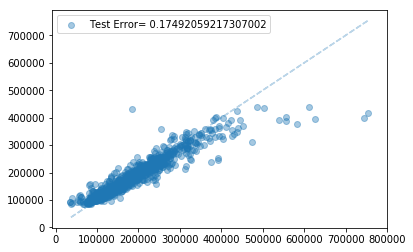

In [326]:
plt.plot(Y,Y,'--',alpha=0.3,label="")
plt.scatter(Y,regressor.predict(X_scaled),alpha=0.4,label="Test Error= "+str(testerror))
plt.legend()
plt.show()

In [318]:
testErrors = []
trainErrors = []

outliers_fractions = np.arange(0.03,0.5,0.05)

for outliers_fraction in outliers_fractions:
    scores_pred, y_pred, threshold = findOutliers_IsolationForest(pdAllData, outliers_fraction)
    outlier_index = np.where(y_pred==-1)[0]
    X_scaled_array = StandardScaler().fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled_array,columns=kept_columnValues)
    
    X_scaled_WO = X_scaled.drop(outlier_index)
    Y_WO = Y.drop(outlier_index)
    X_scaled_outliers = X_scaled.filter(outlier_index,axis=0)
    Y_outliers = Y.filter(outlier_index,axis=0)
    
    testerror, trainerror, regressor = regressionTrees(X=X_scaled_WO,X_outliers=X_scaled_outliers,Y_outliers=Y_outliers,Y=Y_WO,depth=100,min_samples_leaf=5,test_size=0.1,singleTree=False,forest=True,extraTrees=False,nb_estimator=20)
    
    testErrors.append(testerror)
    trainErrors.append(trainerror)


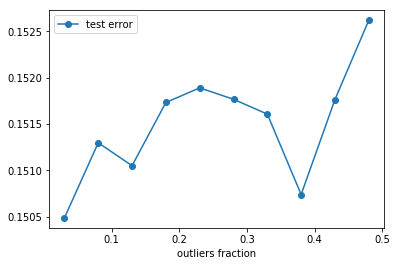

In [319]:
plt.plot(outliers_fractions,testErrors, '-o',label="test error")
#plt.plot(outliers_fractions,trainErrors, label="train error")
plt.xlabel("outliers fraction")
plt.legend()
plt.show()

### SOM

In [5]:
!pip install minisom

  Running setup.py bdist_wheel for minisom: started
  Running setup.py bdist_wheel for minisom: finished with status 'done'
  Stored in directory: C:\Users\gauti_000\AppData\Local\pip\Cache\wheels\bf\41\74\f249faec59290949ed0f67953dadb616efc3e6860c9dcba454
Successfully built minisom


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [148]:
X.shape

(1200, 79)

In [138]:
X_som = np.array(X)

In [171]:
som = MiniSom(128 ,128 , 79, sigma=2.5, learning_rate=0.5)
print("Training...")
som.train_random(X_som, 500)  # random training
print("\n...ready!")
coords = np.array([som.winner(x) for x in X_som])

Training...

...ready!


In [140]:
colors = pdAllData.apply(normHist,axis=1)
scores_pred, y_pred, threshold = findOutliers_IsolationForest(X, 0.05)

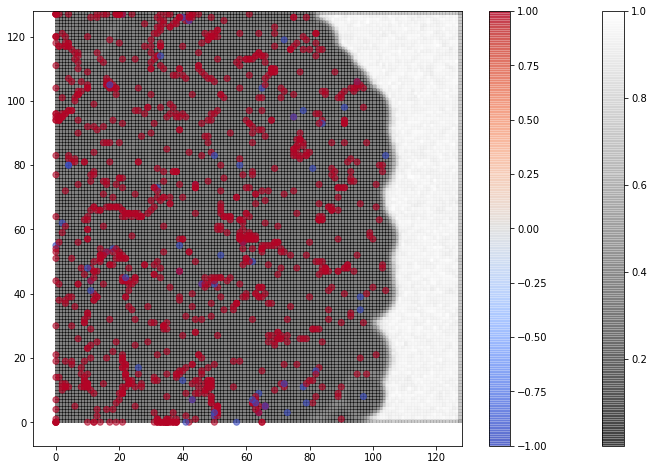

In [170]:
plt.figure(figsize=(12,8))
plt.pcolormesh(som.distance_map().T,alpha=0.5,cmap=cm.get_cmap('gist_gray'))  # plotting the distance map as background#plt.colorbar()
plt.colorbar()
plt.scatter(coords.T[0],coords.T[1],c=y_pred,cmap=cmap,alpha=0.6)
plt.colorbar()
plt.show()